# Importing Libraries

In [1]:
import pandas as pd
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from sklearn.metrics import multilabel_confusion_matrix

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense ,Dropout
from tensorflow.keras.applications import VGG16, VGG19, ResNet50, ResNet101

2024-05-21 06:41:32.806776: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-21 06:41:32.806911: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-21 06:41:32.954411: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Reading Data

In [3]:
complete_data_info = pd.read_csv("/kaggle/input/data/Data_Entry_2017.csv")

# Data Preprocessing

In this the path and file names of each .png image is separated and stored in a two different list and a new dataframe is made with these path and filenames and then it is merged with the complete data file. It is done as there is no path column in the dataset provided and we would need image path later. And then we have dropped unnecessary columns from the the complete_data_info. 

In [4]:
data_base_path = "/kaggle/input/data"

In [5]:
complete_data_imgs_paths = list()
imgs_file_names = list()

for single_img_path in Path(data_base_path).glob("images_*/images/*.png"):
    
    complete_data_imgs_paths.append(str(single_img_path))
    imgs_file_names.append(str(single_img_path.parts[-1]))

In [6]:
complete_data_path_info = pd.DataFrame(data={"Image Index":imgs_file_names,
                                            "Image Path":complete_data_imgs_paths})

In [7]:
complete_data_all_info = complete_data_info.merge(complete_data_path_info,on="Image Index")

In [8]:
complete_data_all_info.drop(complete_data_all_info.columns[2:6],axis=1,inplace=True)

In [9]:
complete_data_all_info.drop(["Unnamed: 11"],axis=1,inplace=True)

# Reading the Testing data

In [10]:
testing_data_info = pd.read_csv("/kaggle/input/data/BBox_List_2017.csv")

# Getting the training data from complete data - testing data

In [11]:
complete_data_all_info = complete_data_all_info.set_index("Image Index")

In [12]:
testing_data_path_info = complete_data_all_info.loc[testing_data_info["Image Index"]]

In [13]:
training_data_all_info = complete_data_all_info.drop(index=testing_data_path_info.index)

In [14]:
testing_data_path_info.reset_index(inplace=True)

Adding path info to the testing data and deleting unnecessary coumns from the testing data

In [15]:
testing_data_all_info = testing_data_info.merge(testing_data_path_info,
                                               on="Image Index")

In [16]:
testing_data_all_info.drop(labels=testing_data_all_info.columns[6:9],axis=1,
                          inplace=True)

In [17]:
training_data_all_info.head()

,Finding Labels,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Image Path
Image Index,,,,,,,
00000001_000.png,Cardiomegaly,PA,2682,2749,0.143,0.143,/kaggle/input/data/images_001/images/00000001_...
00000001_001.png,Cardiomegaly|Emphysema,PA,2894,2729,0.143,0.143,/kaggle/input/data/images_001/images/00000001_...
00000001_002.png,Cardiomegaly|Effusion,PA,2500,2048,0.168,0.168,/kaggle/input/data/images_001/images/00000001_...
00000002_000.png,No Finding,PA,2500,2048,0.171,0.171,/kaggle/input/data/images_001/images/00000002_...
00000003_000.png,Hernia,PA,2582,2991,0.143,0.143,/kaggle/input/data/images_001/images/00000003_...


In [18]:
testing_data_all_info.head()

,Image Index,Finding Label,Bbox [x,y,w,h],Finding Labels,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Image Path
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,Atelectasis,PA,2992,2991,0.143,0.143,/kaggle/input/data/images_006/images/00013118_...
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,Atelectasis|Effusion|Mass,AP,3056,2544,0.139,0.139,/kaggle/input/data/images_007/images/00014716_...
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153,Atelectasis,AP,3056,2544,0.139,0.139,/kaggle/input/data/images_012/images/00029817_...
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034,Atelectasis|Cardiomegaly|Consolidation,AP,2500,2048,0.168,0.168,/kaggle/input/data/images_007/images/00014687_...
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695,Atelectasis,AP,2500,2048,0.168,0.168,/kaggle/input/data/images_008/images/00017877_...


# Getting Unique Diseases

Using the map(), the list of Finding Labels is traversed and the diseases are split where there is a '|' and then it is merged on the list and we got a list of uniques diseaes as a result.  

In [19]:
training_data_all_info["Finding Labels"] = training_data_all_info["Finding Labels"].map(lambda x: x.split("|"))
testing_data_all_info["Finding Labels"] = testing_data_all_info["Finding Labels"].map(lambda x: x.split("|"))

In [20]:
merged_list = list()

for single_list in training_data_all_info["Finding Labels"]:
    
    merged_list = merged_list + single_list

unique_diseases = set(merged_list)
unique_diseases = list(unique_diseases)
unique_diseases.remove("No Finding")
disease2idx = dict(zip(unique_diseases,range(0,len(unique_diseases))))

In [21]:
disease2idx

{'Consolidation': 0,
 'Infiltration': 1,
 'Fibrosis': 2,
 'Atelectasis': 3,
 'Effusion': 4,
 'Nodule': 5,
 'Pleural_Thickening': 6,
 'Pneumothorax': 7,
 'Hernia': 8,
 'Pneumonia': 9,
 'Edema': 10,
 'Mass': 11,
 'Cardiomegaly': 12,
 'Emphysema': 13}

# Multihot Encoding of the Diseases

In this initially the list has zeros and if the image has has diseases the that index will be changed to one. In this we will create a multihot encoded vector for both training and testing data. This is done by ThreadPoolExecutor to manage and create threads. It is done using map(), it maps the method and iterables together immediately and will raise an exception concurrent.futures.TimeoutError if it fails to do so within the timeout limit.

In [22]:
def map_diseases(disease_list):
    
    all_zeros = np.zeros(len(disease2idx),)
    
    for single_disease in disease_list:
        
        if single_disease != "No Finding":
            all_zeros[disease2idx[single_disease]] = 1
        
    return all_zeros

In [23]:
with ThreadPoolExecutor(max_workers=os.cpu_count()) as pool:
    
    multi_hot_encoded_Y_train = np.array(list(pool.map(map_diseases,training_data_all_info["Finding Labels"])))
    multi_hot_encoded_Y_test = np.array(list(pool.map(map_diseases,testing_data_all_info["Finding Labels"])))

In [24]:
training_data_all_info.reset_index(inplace=True)

Training and Testing data are stored in .csv files after all the preprocessing.

In [25]:
training_data_all_info.to_csv("training_data.csv",index=False)
testing_data_all_info.to_csv("testing_data.csv",index=False)

# Training Data Generator

The custom_testing_data_generator() generates minibatches of testing data along with their corresponding multi-hot encoded labels. The minibatch from the training is selected at random and then it is coverted to RGB and then to a numpy array after which the numpy array is being resized and then appended to the empty list that has been created at the starting of the for loop. This is done so as to get the numpy array of the training images that has been selected in that minibatch in a single list. Then multihot encoded vector of the Y_train has been selected for those single images that has been selected in that minibatch and stored in a list.

In [26]:
def custom_training_data_generator(training_data_all_info,multi_hot_encoded_Y_train,mb_size):
    idx = list(training_data_all_info.index)
    np.random.shuffle(idx)
    training_data_all_info=training_data_all_info.iloc[idx]
    multi_hot_encoded_Y_train=multi_hot_encoded_Y_train[idx]
    
    for time_step in range (training_data_all_info.shape[0]//mb_size):
        X_train_mb=list()
        
        for single_img_path in training_data_all_info.iloc[time_step*mb_size:(time_step+1)*mb_size]["Image Path"]:
#             resized_single_img = cv2.resize(Image.open(single_img_path).convert("RGB"),(1024,1024))
    
#             X_train_mb.append(resized_single_img)
             # Open the image using PIL
            pil_img = Image.open(single_img_path).convert("RGB")

            # Convert PIL image to numpy array
            np_img = np.array(pil_img)

            # Resize the numpy array
            resized_single_img = cv2.resize(np_img, (1024, 1024))

            X_train_mb.append(resized_single_img)
            
        X_train_mb=np.array(X_train_mb)
        
        Y_train_mb=multi_hot_encoded_Y_train[time_step*mb_size:(time_step+1)*mb_size]
        
        yield X_train_mb,Y_train_mb

# Testing Data Generator

The custom_testing_data_generator() generates minibatches of testing data along with their corresponding multi-hot encoded labels and rescaled centroids. The minibatch from the training is selected at random and then it is coverted to RGB and then to a numpy array after which the numpy array is being resized and then appended to the empty list that has been created at the starting of the for loop. This is done so as to get the numpy array of the training images that has been selected in that minibatch in a single list. Then multihot encoded vector of the Y_train has been extracted for those single images that has been selected in that minibatch and stored in a list. Then the bounding box coordinates are extracted for the minibatch selected and the centroids are calculated. Then the centroids are rescaled based on the image sizes and a scaling factor of 32.

In [27]:
def custom_testing_data_generator(testing_data_all_info, multi_hot_encoded_Y_test, mb_size):
    
    for time_step in range(testing_data_all_info.shape[0]//mb_size):
        
        X_test_mb = list()
        
        for single_img_path in testing_data_all_info.iloc[time_step*mb_size:(time_step+1)*mb_size]["Image Path"]:
            
            resized_single_img =  cv2.resize(np.array(Image.open(single_img_path).convert("RGB")),(1024,1024))
            X_test_mb.append(resized_single_img)
            
        X_test_mb = np.array(X_test_mb)
        Y_test_mb = multi_hot_encoded_Y_test[time_step*mb_size:(time_step+1)*mb_size]
        
        bbox_mb = np.array(testing_data_all_info.iloc[time_step*mb_size:(time_step+1)*mb_size,2:6])
        centroid_mb = bbox_mb[:,0:2] + 0.5*np.concatenate((bbox_mb[:,3:4],bbox_mb[:,2:3]),axis=1)
        
        img_size_mb = np.array(testing_data_all_info.iloc[time_step*mb_size:(time_step+1)*mb_size,8:10])
        ordered_img_size_mb = np.concatenate((img_size_mb[:,1:2],img_size_mb[:,0:1]),axis=1)
        rescaled_centroid_mb = centroid_mb * (32/ordered_img_size_mb)
        
        yield X_test_mb, Y_test_mb, rescaled_centroid_mb

# Global LSE Pooling Layer

Let X be the input tensor to the layer, with shape (N,H,W,C), where:

* N is the batch size
* H is the height
* W is the width
* C is the number of channels
* r is the hyperparameter

The final output tensor of shape (N,1,1,C)

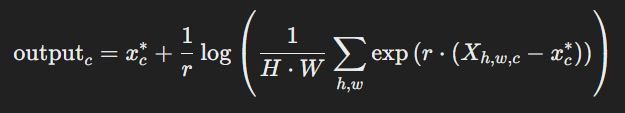

In [28]:
class GlobalLSEPooling2D(tf.keras.layers.Layer):
    
    def __init__(self,r_hyper_param):
        super(GlobalLSEPooling2D, self).__init__()
        self.r = r_hyper_param
        
    def call(self,concatenated_input):
        x_star_per_channel = GlobalMaxPooling2D(keepdims=True)(concatenated_input)
        shifted_pix_values = tf.math.exp(self.r*(concatenated_input - x_star_per_channel))
        avged_output = GlobalAveragePooling2D(keepdims=True)(shifted_pix_values)
        logged_output = (1/self.r)*tf.math.log(avged_output)
        layer_output = x_star_per_channel + logged_output
        
        return layer_output

# Model

In chest_x_ray_cnn(), the model is being made. First, the input is taken and that goes to the four Pretrained CNNS: VGG16,VGG19,RESNET50 and RESNET110. The output of these layers then go to the concatenate layer and then goes to GlobalLSEPooling2D layer then a flatten layer has been added and a dropout layer. Finally the output layer of the dropout layer goes to the dense layer with sigmoid activation function which provides the probability of having disease/(s).  

**Input Layer (1024x1024x3) -> Pretrained Convolutional Base Layers -> Freeze Pretrained Convolutional Base Layers -> Feature Extraction -> Concatenation of Feature Maps -> Global LSE Pooling Layer -> Flattening -> Dropout -> Output Layer -> Output**


In [29]:
def chest_x_ray_cnn():
    
    input_to_cnn = Input(shape=(1024,1024,3))
    
    pretrained_vgg16_conv_base = VGG16(include_top=False,
                                   input_shape=(1024,1024,3))
    pretrained_vgg19_conv_base = VGG19(include_top=False,
                                  input_shape=(1024,1024,3))
    pretrained_resnet50_conv_base = ResNet50(include_top=False,
                                        input_shape=(1024,1024,3))
    pretrained_resnet101_conv_base = ResNet101(include_top=False,
                                          input_shape=(1024,1024,3))

    pretrained_vgg16_conv_base.trainable = False
    pretrained_vgg19_conv_base.trainable = False
    pretrained_resnet50_conv_base.trainable = False
    pretrained_resnet101_conv_base.trainable = False
    
    vgg16_out = pretrained_vgg16_conv_base(input_to_cnn)
    vgg19_out = pretrained_vgg19_conv_base(input_to_cnn)
    resnet50_out = pretrained_resnet50_conv_base(input_to_cnn)
    resnet101_out = pretrained_resnet101_conv_base(input_to_cnn)
    
    concatenated_output = Concatenate()([vgg16_out,vgg19_out,
                                      resnet50_out,resnet101_out])
    
    pooled_output = GlobalLSEPooling2D(r_hyper_param=0.9)(concatenated_output)
    flattened_output = Flatten()(pooled_output)
    dropout_output = Dropout(0.5)(flattened_output)
    
    cnn_out = Dense(units=multi_hot_encoded_Y_train.shape[1],
                    activation="sigmoid")(dropout_output)
    
    return Model(inputs=input_to_cnn,outputs=cnn_out)

In [30]:
our_custom_cnn = chest_x_ray_cnn()

171446536/171446536 [==============================] - 4s 0us/step


In [31]:
our_custom_cnn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1024, 1024, 3)]      0         []                            
                                                                                                  
 vgg16 (Functional)          (None, 32, 32, 512)          1471468   ['input_1[0][0]']             
                                                          8                                       
                                                                                                  
 vgg19 (Functional)          (None, 32, 32, 512)          2002438   ['input_1[0][0]']             
                                                          4                                       
                                                                                              

# Weighted Binary Cross Entropy Loss

As we know our data is imbalanced, so the loss that we would get will be biased. To reduce the biasness of the loss beta_p and beta_n have been introduced.
![](http://cdn.analyticsvidhya.com/wp-content/uploads/2021/03/Screenshot-from-2021-03-03-11-33-29.png)

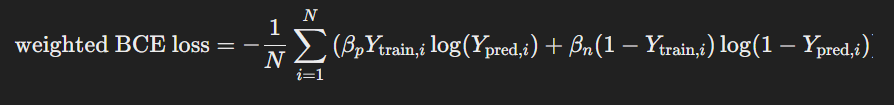

In [32]:
def weighted_bcel(Y_train_mb,Y_pred_mb):
    
    cardinality_p = np.count_nonzero(Y_train_mb)
    cardinality_n = (Y_train_mb.shape[0]*Y_train_mb.shape[1]) - cardinality_p
    
    epsilon = 1e-7
    beta_p = (cardinality_p + cardinality_n + epsilon)/(cardinality_p + epsilon)
    beta_n = (cardinality_p + cardinality_n + epsilon)/(cardinality_n + epsilon)
    
    Y_pred_mb = tf.clip_by_value(Y_pred_mb, epsilon, 1.0 - epsilon)
    return -tf.reduce_mean(tf.reduce_mean(beta_p*Y_train_mb*tf.math.log(Y_pred_mb) \
                          + beta_n*(1-Y_train_mb)*tf.math.log(1-Y_pred_mb),axis=0))

# Performance Metrics

In compute_performance_metrics(), the confusion matix is created using multilabel_confusion_matrix(). And then Accuracy,Recall and Precision has been calculated.
![](https://www.researchgate.net/publication/336402347/figure/fig3/AS:812472659349505@1570719985505/Calculation-of-Precision-Recall-and-Accuracy-in-the-confusion-matrix.ppm)

In [33]:
def compute_performance_metrics(Y_pred,Y_true,thresh):
    
    Y_pred = Y_pred > thresh
    confusion_matrix = multilabel_confusion_matrix(y_true=Y_true,y_pred=Y_pred)
    summed_confusion_matrix = np.sum(confusion_matrix,axis=0)
    
    tp = summed_confusion_matrix[0,0]
    tn = summed_confusion_matrix[1,1]
    fp = summed_confusion_matrix[0,1]
    fn = summed_confusion_matrix[1,0]
    
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    
    return accuracy,precision,recall    

# Center Pixel Coordinates

This function, predicted_center_pixel_cords(), processes a batch of heatmaps to find the coordinates of the maximum value in each channel of each heatmap and then scales these coordinates to match a 224x224 resolution. 

A heatmap is sent to the function as a parameter that has the heatmaps of the diseases possesed in a chest x-ray. There would be stack of heatmaps in this parameter as there are almost 14 diseases so for a single image there would be would be stack of 14 heatmaps.

So, in this function we split each heatmap and try to get the maximum value in these heatmaps and try to store them.

* np.argmax(single_heatmap_channel): Finds the index of the maximum value in the flattened channel.
* np.unravel_index(..., single_heatmap_channel.shape): Converts the flattened index back to 2D coordinates.

And then the stored in a list in the form of a numpy array and normalizing it to a 7*7 channel and 224*244 resolutions.

In [34]:
def predicted_center_pixel_cords(heatmaps):
    
    argmax = list()
    for single_heatmap in heatmaps:
        
        heatmap_channels = cv2.split(single_heatmap)
        argmax_per_heatmap = list()
    
        for single_heatmap_channel in heatmap_channels:    
            single_channel_max_loc = list(np.unravel_index(np.argmax(single_heatmap_channel),single_heatmap_channel.shape))
            argmax_per_heatmap.append(single_channel_max_loc)
        
        argmax.append(np.array(argmax_per_heatmap)/np.array([[7,7]])*224)
        
    return np.array(argmax)

This line of code is using the Keras API to create a new model, conv_base, by extracting a portion of an existing model, our_custom_cnn. The goal of this line is to create a model that shares the same input as our_custom_cnn() but outputs the features from an intermediate layer, specifically the sixth layer (index 5), i.e, Concatenate Layer as we can see in the Model summary .

In [35]:
conv_base = Model(inputs=[our_custom_cnn.input],outputs=[our_custom_cnn.layers[5].output])

Took 10 data to train the model as the whole data would require GPU.

In [36]:
train_data = training_data_all_info[0:10]

In [37]:
train_data.head()

,Image Index,Finding Labels,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Image Path
0,00000001_000.png,[Cardiomegaly],PA,2682,2749,0.143,0.143,/kaggle/input/data/images_001/images/00000001_...
1,00000001_001.png,"[Cardiomegaly, Emphysema]",PA,2894,2729,0.143,0.143,/kaggle/input/data/images_001/images/00000001_...
2,00000001_002.png,"[Cardiomegaly, Effusion]",PA,2500,2048,0.168,0.168,/kaggle/input/data/images_001/images/00000001_...
3,00000002_000.png,[No Finding],PA,2500,2048,0.171,0.171,/kaggle/input/data/images_001/images/00000002_...
4,00000003_000.png,[Hernia],PA,2582,2991,0.143,0.143,/kaggle/input/data/images_001/images/00000003_...


In [38]:
mhe_Ytrain = multi_hot_encoded_Y_train[0:10]

In [39]:
mhe_Ytrain[0:2]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.]])

# Gradient Tape

GradientTape is a mathematical tool for automatic differentiation (autodiff), which is the core functionality of TensorFlow. It does not "track" the autodiff, it is a key part of performing the autodiff. It is used to record ("tape") a sequence of operations performed upon some input and producing some output, so that the output can be differentiated with respect to the input (via backpropagation / reverse-mode autodiff) (in order to then perform gradient descent optimisation).

With eager execution enabled, Tensorflow will calculate the values of tensors as they occur in your code. This means that it won't precompute a static graph for which inputs are fed in through placeholders. This means to back propagate errors, you have to keep track of the gradients of your computation and then apply these gradients to an optimiser.

This is very different from running without eager execution, where you would build a graph and then simply use sess.run to evaluate your loss and then pass this into an optimiser directly.

Fundamentally, because tensors are evaluated immediately, you don't have a graph to calculate gradients and so you need a gradient tape. It is not so much that it is just used for visualisation, but more that you cannot implement a gradient descent in eager mode without it.

Obviously, Tensorflow could just keep track of every gradient for every computation on every tf.Variable. However, that could be a huge performance bottleneck. They expose a gradient tape so that you can control what areas of your code need the gradient information. Note that in non-eager mode, this will be statically determined based on the computational branches that are descendants of your loss but in eager mode there is no static graph and so no way of knowing.

# Training

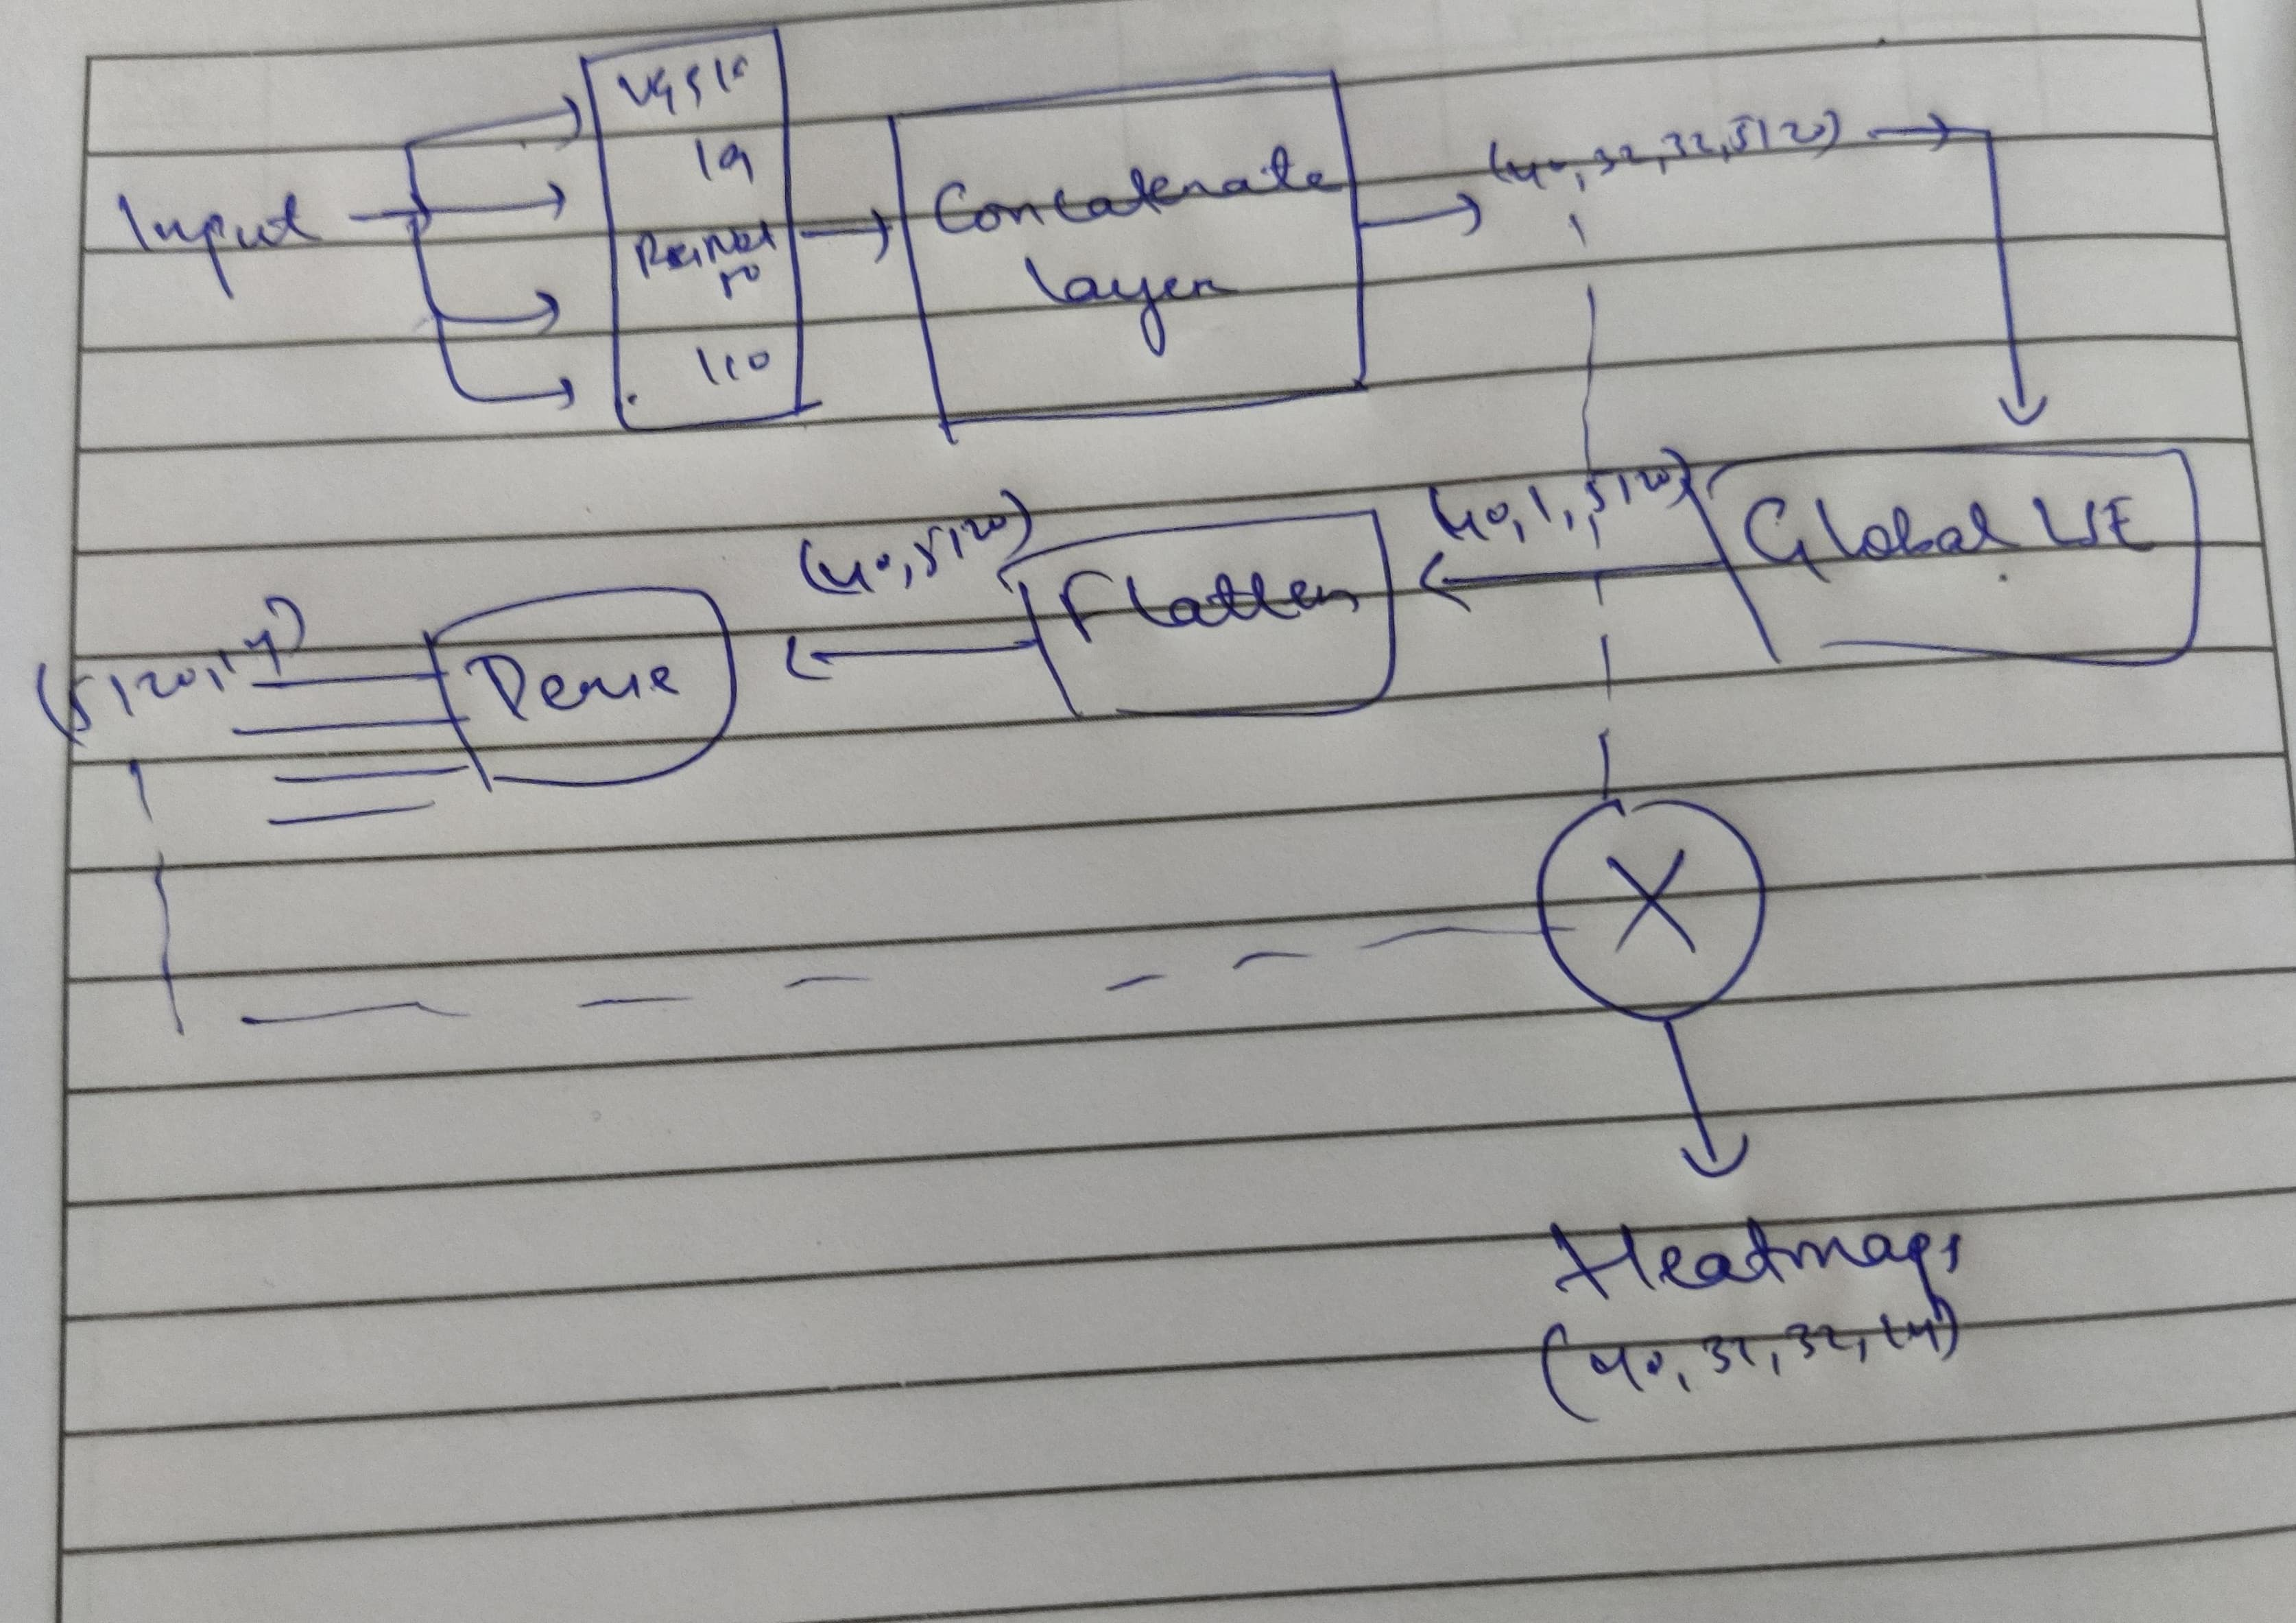

Learning Rate Scheduler is used to adjust the learning rate as the epochs increases. Then the model is compiled using the optimizer RMSprop with initial learning rate of 0.001 and loss is equals to the function that we made weighted_bcel and metics equals to Accuracy. The Learning Rate Scheduler Callback creates a callback to update the learning rate according to the lr_scheduler function.

Gradient Tape is used to calculate the loss and gardients. Predicted Y of the minibatch gets the model prediction and the loss is calculated. The gradient tape is used within a with block to compute the forward pass and loss, and then calculate the gradients. The computed gradients are then passed to the optimizer to update the model weights.
* Gradient Tape: Used for recording operations and computing gradients of the loss function with respect to model parameters.
* Gradient Update: Involves applying the computed gradients to update the model parameters using an optimization algorithm.

Metrics are calculated and printed.

Then, the output of the Conacatenate layer and Dense layer are fetched and heatmaps are generated multipying (matrix multiplication) them. Then the centre pixels coordinates are predicted using the predicted_center_pixel_cords().

In [40]:
from tensorflow.keras.callbacks import LearningRateScheduler

In [41]:
def lr_scheduler(epoch, lr):
    if epoch < 2:
        return lr  # Keep the initial learning rate for the first 10 epochs
    else:
        return lr * tf.math.exp(-0.1)  # Exponential decay with a decay rate of 0.1 every epoch after the 10th epoch


optimizer = tf.keras.optimizers.RMSprop(lr=0.001)
our_custom_cnn.compile(optimizer=optimizer, loss=weighted_bcel, metrics=['accuracy'])
lr_scheduler_callback = LearningRateScheduler(lr_scheduler)


num_epochs = 2
time_steps = 0
mb_size = 2

for epoch in range(num_epochs):
    for X_train_mb,Y_train_mb in custom_training_data_generator(train_data,mhe_Ytrain,mb_size):
        
        with tf.GradientTape() as tape:
            
            Y_pred_mb = our_custom_cnn(X_train_mb)
            w_bcel_value = weighted_bcel(Y_train_mb,Y_pred_mb)
            
        gradients = tape.gradient(w_bcel_value,our_custom_cnn.trainable_weights)
        optimizer.apply_gradients(zip(gradients,our_custom_cnn.trainable_weights))
        
        train_acc,train_pre,train_rec = compute_performance_metrics(Y_pred_mb,Y_train_mb,0.5)
        
        time_steps += 1
            
        print("\n\nEpoch # {}, Time Step # {}".format(epoch,time_steps))
        print("WBCEL Value = {}, Training Accuracy = {}, Training Precision = {}, Training Recall = {}".format(w_bcel_value,
                                                                                                              train_acc,
                                                                                                              train_pre,
                                                                                                              train_rec))
        conv_base_out = conv_base(X_train_mb).numpy()
        cls_head_params = our_custom_cnn.layers[-1].weights[0].numpy()
        
        heatmaps = np.matmul(conv_base_out,cls_head_params)
        pred_center_pix_loc = predicted_center_pixel_cords(heatmaps)
        
        print("Epoch # {}, Time Step # {}, Predicted Location of Each Disease for Chest X-rays in Mini Batch:".format(epoch,
                                                                                                                     time_steps))
        print(pred_center_pix_loc)



Epoch # 0, Time Step # 1
WBCEL Value = 2.201453447341919, Training Accuracy = 0.6785714285714286, Training Precision = 0.6666666666666666, Training Recall = 1.0
Epoch # 0, Time Step # 1, Predicted Location of Each Disease for Chest X-rays in Mini Batch:
[[[  0. 224.]
  [  0. 352.]
  [384. 928.]
  [ 32. 896.]
  [256. 736.]
  [  0. 960.]
  [736. 256.]
  [  0. 160.]
  [  0. 224.]
  [  0. 704.]
  [  0. 128.]
  [  0. 480.]
  [  0. 704.]
  [  0. 512.]]

 [[  0. 832.]
  [288.   0.]
  [224. 864.]
  [ 64. 800.]
  [ 32. 160.]
  [ 32.  32.]
  [768. 832.]
  [608.   0.]
  [ 32. 832.]
  [  0. 320.]
  [  0. 576.]
  [704.  32.]
  [320. 992.]
  [  0. 512.]]]


Epoch # 0, Time Step # 2
WBCEL Value = 16.118093490600586, Training Accuracy = 0.9285714285714286, Training Precision = 1.0, Training Recall = 0.9285714285714286
Epoch # 0, Time Step # 2, Predicted Location of Each Disease for Chest X-rays in Mini Batch:
[[[  0. 960.]
  [  0. 512.]
  [ 64. 352.]
  [288.   0.]
  [928. 768.]
  [864. 864.]
  [672.

Getting 4 data for testing the model

In [42]:
test_data = testing_data_all_info[0:4]

In [43]:
mhe_Ytest = multi_hot_encoded_Y_test[0:4]

# Testing

Threshold Probabilities and Fold Size:

* thresh_probability: Array of threshold probabilities from 0.3 to 0.4 (inclusive) in steps of 0.1.
* fold_size: Number of samples in each fold.
* K: Number of folds, calculated as the total number of samples divided by the fold size.

Similar steps are done to test the model:-

* Create Cross-Validation and Testing Data Splits
* Create Multi-Hot Encoded Labels for Cross-Validation and Testing
* Generate Data for Cross-Validation and Testing
* Predict and Compute Performance Metrics for Cross-Validation Data and Testing Data
* Generate Heatmaps for Cross-Validation Data and Testing Data
* Print Cross-Validation and Testing Metrics

In [44]:
# print("\n\n\n\n")

# thresh_probability = np.arange(start=0.3,stop=0.5,step=0.1)
# fold_size = 2
# K = testing_data_all_info.shape[0]//fold_size

# for fold_idx in range(K):
#     for p_thresh in thresh_probability:
        
#         cv_data = pd.concat([test_data[0:(fold_idx*fold_size)],
#                              test_data[(fold_idx+1)*fold_size:]],axis=0)
        
#         testing_data = test_data[(fold_idx*fold_size):(fold_idx+1)*fold_size]
        
#         multi_hot_encoded_Y_cv = np.concatenate((mhe_Ytest[0:(fold_idx*fold_size)],
#                                                 mhe_Ytest[(fold_idx+1)*fold_size:]),
#                                                 axis=0)
        
#         multi_hot_encoded_Y_test = mhe_Ytest[(fold_idx*fold_size):(fold_idx+1)*fold_size]
        
#         X_cv, Y_cv, rescaled_centroid_cv = custom_testing_data_generator(cv_data,multi_hot_encoded_Y_cv,
#                                                                          cv_data.shape[0])
        
#         X_test, Y_test, rescaled_centroid_test = custom_testing_data_generator(testing_data,
#                                                                                multi_hot_encoded_Y_test,
#                                                                                testing_data.shape[0])
        
#         Y_pred_cv = our_custom_cnn(X_cv)
#         cv_acc,cv_pre,cv_rec = compute_performance_metrics(Y_pred_cv,Y_cv,p_thresh)
        
#         cv_conv_base_out = conv_base(X_cv).numpy()
#         cv_heatmaps = np.matmul(cv_conv_base_out,cls_head_weights)
        
#         Y_pred_test = our_custom_cnn(X_test)
#         test_acc,test_pre,test_rec = compute_performance_metrics(Y_pred_test,Y_test,p_thresh)
        
#         test_conv_base_out = conv_base(X_test).numpy()
#         test_heatmaps = np.matmul(test_conv_base_out,cls_head_weights)
        
#         print("Threshold Probability: {}, CV Acc: {}, CV Prec: {}, CV Rec: {}".format(p_thresh,cv_acc,
#                                                                                             cv_pre,
#                                                                                             cv_rec))
        
#         print("Threshold Probability: {}, Test Acc: {}, Test Prec: {}, Test Rec: {}".format(p_thresh,
#                                                                                            test_acc,
#                                                                                            test_pre,
#                                                                                            test_rec))

In [45]:
x_test, y_test, z_test = custom_testing_data_generator(test_data, mhe_Ytest, 2 ).__next__()

In [46]:
x_test.shape

(2, 1024, 1024, 3)

In [47]:
p_thresh = 0.3
Y_pred_test = our_custom_cnn(x_test)
test_acc,test_pre,test_rec = compute_performance_metrics(Y_pred_test,y_test,p_thresh)
test_conv_base_out = conv_base(x_test).numpy()
test_heatmaps = np.matmul(test_conv_base_out,cls_head_params)
print("Threshold Probability: {}, Test Acc: {}, Test Prec: {}, Test Rec: {}".format(p_thresh,
                                                                                           test_acc,
                                                                                           test_pre,
                                                                                           test_rec))

Threshold Probability: 0.3, Test Acc: 0.8571428571428571, Test Prec: 1.0, Test Rec: 0.8571428571428571
